In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2022-12-09 19:35:06.023196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 19:35:06.249323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 19:35:06.249345: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-09 19:35:06.956145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Kitchenware Classification

Competition Link: [Insert link gere]
Dataset: [Insert link here]

Create the ff:
- Brief description of the project
- How to download the dataset

General Steps:
- Gather the datasets using ImageDataGenerator() and flow_from_directory
- Create the base model. Loading the Xception network and remove the dense layers (include_top=False). Since we dont want to retrain our convolutional layer, we use trainable = False
- create the final model with the base_model, pooling and dense layer. all of this will be used for the inputs and outputs parameter for the final model
- Train the Model
- adjust the learning rate
- Checkpointing
- Adding more layers
- Regularization and dropout
- Data augmentation
- Test the model

## Dataset

In [2]:
!pwd

/home/chanchan/Documents/all_about_data/kitchenware_classification


In [3]:
!ls

dataset  notebook.ipynb  requirements.txt


In [4]:
import os

Set the project directory

In [5]:
project_dir = '.'
dir_list = os.listdir(project_dir)
dir_list

['.ipynb_checkpoints',
 'dataset',
 '.gitignore',
 '.venv',
 'notebook.ipynb',
 'requirements.txt',
 '.git']

Set the dataset directory

In [6]:
dataset_dir = project_dir + '/dataset'
dataset_dir

'./dataset'

In [7]:
dir_list = os.listdir(dataset_dir)
dir_list

['sample_submission.csv',
 'images',
 'test_images',
 'train.csv',
 'kitchenware-classification.zip',
 'sorted_images',
 'test.csv']

In [8]:
base_images_dir = dataset_dir + '/images'

In [9]:
dir_list = os.listdir(base_images_dir)
dir_list

['1834.jpg',
 '6193.jpg',
 '5415.jpg',
 '1454.jpg',
 '7560.jpg',
 '6083.jpg',
 '2429.jpg',
 '5577.jpg',
 '5982.jpg',
 '6620.jpg',
 '0278.jpg',
 '2360.jpg',
 '4343.jpg',
 '7782.jpg',
 '6461.jpg',
 '3378.jpg',
 '0080.jpg',
 '3470.jpg',
 '8198.jpg',
 '6910.jpg',
 '2634.jpg',
 '8498.jpg',
 '0901.jpg',
 '4103.jpg',
 '2159.jpg',
 '8596.jpg',
 '0274.jpg',
 '0319.jpg',
 '7846.jpg',
 '6021.jpg',
 '2348.jpg',
 '8487.jpg',
 '4580.jpg',
 '0279.jpg',
 '1439.jpg',
 '5426.jpg',
 '6643.jpg',
 '3626.jpg',
 '1068.jpg',
 '8291.jpg',
 '6719.jpg',
 '2104.jpg',
 '8520.jpg',
 '2082.jpg',
 '5525.jpg',
 '3543.jpg',
 '5611.jpg',
 '0136.jpg',
 '3357.jpg',
 '4862.jpg',
 '5958.jpg',
 '6099.jpg',
 '2229.jpg',
 '2033.jpg',
 '1641.jpg',
 '3529.jpg',
 '8658.jpg',
 '3390.jpg',
 '1590.jpg',
 '4493.jpg',
 '6357.jpg',
 '0851.jpg',
 '6844.jpg',
 '1464.jpg',
 '3632.jpg',
 '3417.jpg',
 '7039.jpg',
 '7496.jpg',
 '2826.jpg',
 '1309.jpg',
 '7791.jpg',
 '8891.jpg',
 '8299.jpg',
 '0996.jpg',
 '8581.jpg',
 '7003.jpg',
 '4796.jpg',

Directories

In [10]:
project_dir = '.'
dataset_dir = project_dir + '/dataset'
base_images_dir = dataset_dir + '/images'

In [11]:
dirs = {
    'project_dir': '.',
    'dataset_dir': project_dir + '/dataset',
    'base_images_dir': dataset_dir + '/images',
}

In [12]:
file_info = pd.read_csv(dataset_dir + '/train.csv', dtype = 'string')

In [13]:
file_info

,Id,label
0,0560,glass
1,4675,cup
2,0875,glass
3,4436,spoon
4,8265,plate
...,...,...
5554,6742,cup
5555,1574,cup
5556,6746,knife
5557,3562,cup


In [14]:
file_info['filename'] = file_info['Id'].astype(str) + '.jpg'

In [15]:
file_info

,Id,label,filename
0,0560,glass,0560.jpg
1,4675,cup,4675.jpg
2,0875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg
...,...,...,...
5554,6742,cup,6742.jpg
5555,1574,cup,1574.jpg
5556,6746,knife,6746.jpg
5557,3562,cup,3562.jpg


In [16]:
# Check if there are duplicate values
file_info.loc[file_info.duplicated(), :]

,Id,label,filename


In [17]:
file_info = file_info.sort_values(['label','Id'], ascending = [True, True])
file_info

,Id,label,filename
3226,0003,cup,0003.jpg
282,0006,cup,0006.jpg
911,0009,cup,0009.jpg
3973,0017,cup,0017.jpg
1666,0020,cup,0020.jpg
...,...,...,...
2631,9364,spoon,9364.jpg
4818,9398,spoon,9398.jpg
4753,9424,spoon,9424.jpg
3576,9432,spoon,9432.jpg


In [58]:
sample_df = file_info
sample_df['rank'] = sample_df.groupby(['label'])['Id'].rank('dense', ascending=True)
sample_df = sample_df.reset_index(drop=True)
sample_df

,Id,label,filename,rank
0,0003,cup,0003.jpg,1.0
1,0006,cup,0006.jpg,2.0
2,0009,cup,0009.jpg,3.0
3,0017,cup,0017.jpg,4.0
4,0020,cup,0020.jpg,5.0
...,...,...,...,...
5554,9364,spoon,9364.jpg,985.0
5555,9398,spoon,9398.jpg,986.0
5556,9424,spoon,9424.jpg,987.0
5557,9432,spoon,9432.jpg,988.0


In [19]:
sample_df.groupby('label')['rank'].max()

label
cup      1135.0
fork      557.0
glass     742.0
knife     909.0
plate    1227.0
spoon     989.0
Name: rank, dtype: float64

In [20]:
dir_list = os.listdir(base_images_dir)
dir_list

['1834.jpg',
 '6193.jpg',
 '5415.jpg',
 '1454.jpg',
 '7560.jpg',
 '6083.jpg',
 '2429.jpg',
 '5577.jpg',
 '5982.jpg',
 '6620.jpg',
 '0278.jpg',
 '2360.jpg',
 '4343.jpg',
 '7782.jpg',
 '6461.jpg',
 '3378.jpg',
 '0080.jpg',
 '3470.jpg',
 '8198.jpg',
 '6910.jpg',
 '2634.jpg',
 '8498.jpg',
 '0901.jpg',
 '4103.jpg',
 '2159.jpg',
 '8596.jpg',
 '0274.jpg',
 '0319.jpg',
 '7846.jpg',
 '6021.jpg',
 '2348.jpg',
 '8487.jpg',
 '4580.jpg',
 '0279.jpg',
 '1439.jpg',
 '5426.jpg',
 '6643.jpg',
 '3626.jpg',
 '1068.jpg',
 '8291.jpg',
 '6719.jpg',
 '2104.jpg',
 '8520.jpg',
 '2082.jpg',
 '5525.jpg',
 '3543.jpg',
 '5611.jpg',
 '0136.jpg',
 '3357.jpg',
 '4862.jpg',
 '5958.jpg',
 '6099.jpg',
 '2229.jpg',
 '2033.jpg',
 '1641.jpg',
 '3529.jpg',
 '8658.jpg',
 '3390.jpg',
 '1590.jpg',
 '4493.jpg',
 '6357.jpg',
 '0851.jpg',
 '6844.jpg',
 '1464.jpg',
 '3632.jpg',
 '3417.jpg',
 '7039.jpg',
 '7496.jpg',
 '2826.jpg',
 '1309.jpg',
 '7791.jpg',
 '8891.jpg',
 '8299.jpg',
 '0996.jpg',
 '8581.jpg',
 '7003.jpg',
 '4796.jpg',

In [21]:
len(dir_list)

9367

In [22]:
count_jpg = len([i for i in dir_list if i[-3:] == 'jpg'])
count_jpg

9367

So all files are in jpeg format

**Check duplicate images**

*First algorithm*

In [23]:
from imagededup.methods import PHash
phasher = PHash()

encodings = phasher.encode_images(image_dir=base_images_dir)

duplicates = phasher.find_duplicates(encoding_map=encodings)

2022-12-09 19:35:21,956: INFO Start: Calculating hashes...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9367/9367 [00:13<00:00, 706.00it/s]
2022-12-09 19:35:35,456: INFO End: Calculating hashes!
2022-12-09 19:35:35,458: INFO Start: Evaluating hamming distances for getting duplicates
2022-12-09 19:35:35,459: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9367/9367 [00:06<00:00, 1339.50it/s]
2022-12-09 19:35:42,579: INFO End: Retrieving duplicates using Cython Brute force algorithm
2022-12-09 19:35:42,579: INFO End: Evaluating hamming distances for getting duplicates


In [24]:
duplicates

{'1834.jpg': [],
 '6193.jpg': [],
 '5415.jpg': ['2292.jpg'],
 '1454.jpg': [],
 '7560.jpg': [],
 '6083.jpg': [],
 '2429.jpg': [],
 '5577.jpg': ['0413.jpg', '1878.jpg'],
 '5982.jpg': [],
 '6620.jpg': [],
 '0278.jpg': ['4529.jpg'],
 '2360.jpg': ['7859.jpg'],
 '4343.jpg': ['3338.jpg'],
 '7782.jpg': [],
 '6461.jpg': [],
 '3378.jpg': [],
 '0080.jpg': [],
 '3470.jpg': [],
 '8198.jpg': [],
 '6910.jpg': [],
 '2634.jpg': [],
 '8498.jpg': [],
 '0901.jpg': [],
 '4103.jpg': [],
 '2159.jpg': [],
 '8596.jpg': [],
 '0274.jpg': ['2412.jpg'],
 '0319.jpg': [],
 '7846.jpg': [],
 '6021.jpg': [],
 '2348.jpg': [],
 '8487.jpg': [],
 '4580.jpg': ['3760.jpg', '4538.jpg', '8904.jpg'],
 '0279.jpg': [],
 '1439.jpg': [],
 '5426.jpg': [],
 '6643.jpg': [],
 '3626.jpg': ['6205.jpg'],
 '1068.jpg': [],
 '8291.jpg': [],
 '6719.jpg': [],
 '2104.jpg': [],
 '8520.jpg': [],
 '2082.jpg': ['6998.jpg', '5386.jpg'],
 '5525.jpg': [],
 '3543.jpg': [],
 '5611.jpg': [],
 '0136.jpg': ['7323.jpg'],
 '3357.jpg': [],
 '4862.jpg': [],
 '

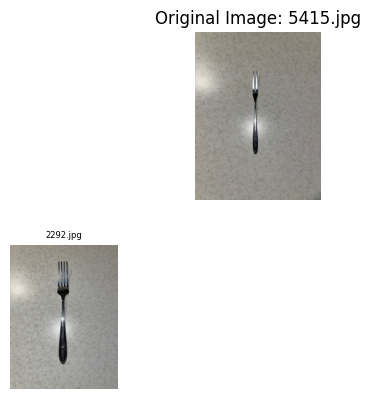

In [25]:
from imagededup.utils import plot_duplicates
plot_duplicates(image_dir=base_images_dir,
                duplicate_map=duplicates,
                filename='5415.jpg')

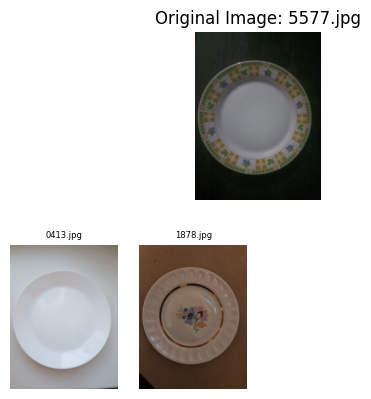

In [26]:
from imagededup.utils import plot_duplicates
plot_duplicates(image_dir=base_images_dir,
                duplicate_map=duplicates,
                filename='5577.jpg')

*First algorithm*

In [26]:
from collections import defaultdict
from hashlib import md5
from pathlib import Path

import PIL

In [27]:
image_dir = Path(base_images_dir)

In [28]:
hash_dict = defaultdict(list)
for image in image_dir.glob('*.jpg'):
    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

9361

In [29]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[PosixPath('dataset/images/7063.jpg'), PosixPath('dataset/images/7196.jpg')]
[PosixPath('dataset/images/8532.jpg'), PosixPath('dataset/images/6833.jpg')]
[PosixPath('dataset/images/0237.jpg'), PosixPath('dataset/images/4234.jpg')]
[PosixPath('dataset/images/5428.jpg'), PosixPath('dataset/images/7103.jpg')]
[PosixPath('dataset/images/3458.jpg'), PosixPath('dataset/images/4162.jpg')]
[PosixPath('dataset/images/7469.jpg'), PosixPath('dataset/images/6624.jpg')]


12

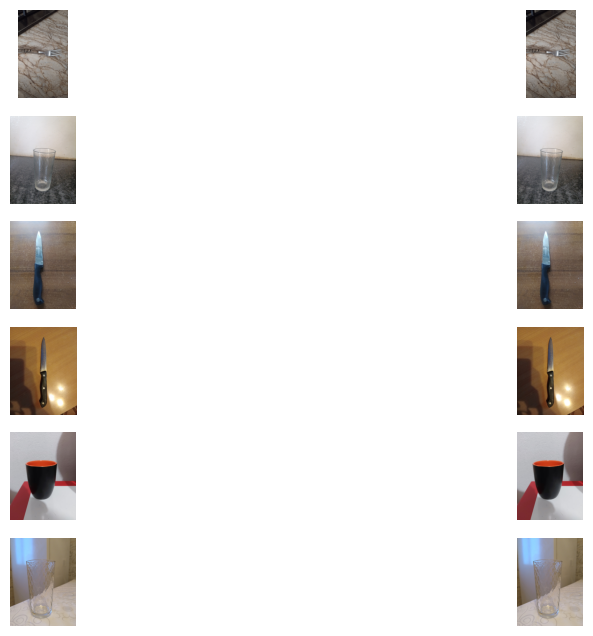

In [30]:
plt.figure(figsize=(12,8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    plt.subplot(6,2, idx+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

Since there are duplicates, it might affect the model performance. But for now, we will proceed

**Dataset Preparation**

In [31]:
dirs

{'project_dir': '.',
 'dataset_dir': './dataset',
 'base_images_dir': './dataset/images'}

In [32]:
dirs['project_dir']

'.'

In [33]:
file_info.head()

,Id,label,filename,rank
3226,0003,cup,0003.jpg,1.0
282,0006,cup,0006.jpg,2.0
911,0009,cup,0009.jpg,3.0
3973,0017,cup,0017.jpg,4.0
1666,0020,cup,0020.jpg,5.0


In [34]:
dir_list = os.listdir(dirs['base_images_dir'])
dir_list

['1834.jpg',
 '6193.jpg',
 '5415.jpg',
 '1454.jpg',
 '7560.jpg',
 '6083.jpg',
 '2429.jpg',
 '5577.jpg',
 '5982.jpg',
 '6620.jpg',
 '0278.jpg',
 '2360.jpg',
 '4343.jpg',
 '7782.jpg',
 '6461.jpg',
 '3378.jpg',
 '0080.jpg',
 '3470.jpg',
 '8198.jpg',
 '6910.jpg',
 '2634.jpg',
 '8498.jpg',
 '0901.jpg',
 '4103.jpg',
 '2159.jpg',
 '8596.jpg',
 '0274.jpg',
 '0319.jpg',
 '7846.jpg',
 '6021.jpg',
 '2348.jpg',
 '8487.jpg',
 '4580.jpg',
 '0279.jpg',
 '1439.jpg',
 '5426.jpg',
 '6643.jpg',
 '3626.jpg',
 '1068.jpg',
 '8291.jpg',
 '6719.jpg',
 '2104.jpg',
 '8520.jpg',
 '2082.jpg',
 '5525.jpg',
 '3543.jpg',
 '5611.jpg',
 '0136.jpg',
 '3357.jpg',
 '4862.jpg',
 '5958.jpg',
 '6099.jpg',
 '2229.jpg',
 '2033.jpg',
 '1641.jpg',
 '3529.jpg',
 '8658.jpg',
 '3390.jpg',
 '1590.jpg',
 '4493.jpg',
 '6357.jpg',
 '0851.jpg',
 '6844.jpg',
 '1464.jpg',
 '3632.jpg',
 '3417.jpg',
 '7039.jpg',
 '7496.jpg',
 '2826.jpg',
 '1309.jpg',
 '7791.jpg',
 '8891.jpg',
 '8299.jpg',
 '0996.jpg',
 '8581.jpg',
 '7003.jpg',
 '4796.jpg',

In [35]:
import shutil

In [36]:
sorted_dataset = dataset_dir + '/sorted_dataset'

if os.path.exists(sorted_dataset):
    shutil.rmtree(sorted_dataset)
os.makedirs(sorted_dataset)

In [37]:
file_loc = dict(zip(file_info['filename'],file_info['label']))
file_loc

{'0003.jpg': 'cup',
 '0006.jpg': 'cup',
 '0009.jpg': 'cup',
 '0017.jpg': 'cup',
 '0020.jpg': 'cup',
 '0029.jpg': 'cup',
 '0041.jpg': 'cup',
 '0052.jpg': 'cup',
 '0060.jpg': 'cup',
 '0061.jpg': 'cup',
 '0066.jpg': 'cup',
 '0069.jpg': 'cup',
 '0073.jpg': 'cup',
 '0082.jpg': 'cup',
 '0091.jpg': 'cup',
 '0094.jpg': 'cup',
 '0100.jpg': 'cup',
 '0104.jpg': 'cup',
 '0108.jpg': 'cup',
 '0120.jpg': 'cup',
 '0126.jpg': 'cup',
 '0129.jpg': 'cup',
 '0137.jpg': 'cup',
 '0142.jpg': 'cup',
 '0148.jpg': 'cup',
 '0149.jpg': 'cup',
 '0151.jpg': 'cup',
 '0153.jpg': 'cup',
 '0173.jpg': 'cup',
 '0203.jpg': 'cup',
 '0209.jpg': 'cup',
 '0214.jpg': 'cup',
 '0236.jpg': 'cup',
 '0269.jpg': 'cup',
 '0270.jpg': 'cup',
 '0276.jpg': 'cup',
 '0284.jpg': 'cup',
 '0290.jpg': 'cup',
 '0294.jpg': 'cup',
 '0299.jpg': 'cup',
 '0317.jpg': 'cup',
 '0320.jpg': 'cup',
 '0326.jpg': 'cup',
 '0327.jpg': 'cup',
 '0330.jpg': 'cup',
 '0331.jpg': 'cup',
 '0340.jpg': 'cup',
 '0342.jpg': 'cup',
 '0354.jpg': 'cup',
 '0360.jpg': 'cup',


In [38]:
dirs

{'project_dir': '.',
 'dataset_dir': './dataset',
 'base_images_dir': './dataset/images'}

In [39]:
dirs['target_images_dir'] = dirs['dataset_dir'] + '/sorted_images'
dirs

{'project_dir': '.',
 'dataset_dir': './dataset',
 'base_images_dir': './dataset/images',
 'target_images_dir': './dataset/sorted_images'}

In [40]:
# Move all the training images
for file, label in file_loc.items():
    
    src = dirs['base_images_dir'] + '/' + file
    dst = dirs['target_images_dir'] + '/' + label + '/' + file
    
    if os.path.exists(dirs['target_images_dir'] + '/' + label):
        shutil.copy(src, dst)
    else:
        os.makedirs(dirs['target_images_dir'] + '/' + label)
        shutil.copy(src, dst)

In [41]:
count_train = sum([len(files) for r, d, files in os.walk(dirs['target_images_dir'])])
count_train

5559

In [42]:
test_info = pd.read_csv(dirs['dataset_dir'] + '/test.csv', dtype = 'string')
test_info

,Id
0,0678
1,3962
2,9271
3,5133
4,8842
...,...
3803,7626
3804,2052
3805,8827
3806,2299


In [46]:
test_list = test_info['Id'].tolist()
test_list = [s + '.jpg' for s in test_list]
test_list

['0678.jpg',
 '3962.jpg',
 '9271.jpg',
 '5133.jpg',
 '8842.jpg',
 '8256.jpg',
 '4622.jpg',
 '2775.jpg',
 '5900.jpg',
 '6372.jpg',
 '0781.jpg',
 '4827.jpg',
 '6886.jpg',
 '7823.jpg',
 '1958.jpg',
 '0044.jpg',
 '2386.jpg',
 '1311.jpg',
 '7053.jpg',
 '9204.jpg',
 '8314.jpg',
 '0766.jpg',
 '9102.jpg',
 '5210.jpg',
 '3249.jpg',
 '2272.jpg',
 '1637.jpg',
 '0966.jpg',
 '7878.jpg',
 '8154.jpg',
 '2496.jpg',
 '5236.jpg',
 '1460.jpg',
 '6080.jpg',
 '8876.jpg',
 '1813.jpg',
 '6968.jpg',
 '8814.jpg',
 '4220.jpg',
 '1183.jpg',
 '0145.jpg',
 '0538.jpg',
 '2880.jpg',
 '4073.jpg',
 '0997.jpg',
 '0248.jpg',
 '7913.jpg',
 '0000.jpg',
 '2154.jpg',
 '2238.jpg',
 '8696.jpg',
 '4018.jpg',
 '2549.jpg',
 '8811.jpg',
 '6892.jpg',
 '6162.jpg',
 '2408.jpg',
 '1823.jpg',
 '5082.jpg',
 '7695.jpg',
 '8858.jpg',
 '3699.jpg',
 '7248.jpg',
 '8457.jpg',
 '6262.jpg',
 '2946.jpg',
 '0288.jpg',
 '4850.jpg',
 '8851.jpg',
 '7800.jpg',
 '3279.jpg',
 '9054.jpg',
 '4469.jpg',
 '4779.jpg',
 '1699.jpg',
 '7820.jpg',
 '2853.jpg',

In [47]:
dirs

{'project_dir': '.',
 'dataset_dir': './dataset',
 'base_images_dir': './dataset/images',
 'target_images_dir': './dataset/sorted_images'}

In [48]:
dirs['target_img_dir_test'] = dirs['dataset_dir'] + '/test_images'

In [49]:
for file in test_list:
    
    src = dirs['base_images_dir'] + '/' + file
    dst = dirs['target_img_dir_test'] + '/' + file
    
    if os.path.exists(dirs['target_img_dir_test']):
        shutil.copy(src, dst)
    else:
        os.makedirs(dirs['target_img_dir_test'])
        shutil.copy(src, dst)

In [50]:
count_test = sum([len(files) for r, d, files in os.walk(dirs['target_img_dir_test'])])
count_test

3808

In [51]:
count_train + count_test

9367

Same count with the images directory

In [68]:
subd={}
for fn in Path(dirs['target_images_dir']).glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd[key]=subd.get(key, 0)+1

In [69]:
subd

{'dataset/sorted_images/cup': 794,
 'dataset/sorted_images/fork': 390,
 'dataset/sorted_images/plate': 859,
 'dataset/sorted_images/glass': 519,
 'dataset/sorted_images/spoon': 692,
 'dataset/sorted_images/knife': 636}

In [59]:
sample_df

,Id,label,filename,rank
0,0003,cup,0003.jpg,1.0
1,0006,cup,0006.jpg,2.0
2,0009,cup,0009.jpg,3.0
3,0017,cup,0017.jpg,4.0
4,0020,cup,0020.jpg,5.0
...,...,...,...,...
5554,9364,spoon,9364.jpg,985.0
5555,9398,spoon,9398.jpg,986.0
5556,9424,spoon,9424.jpg,987.0
5557,9432,spoon,9432.jpg,988.0


In [63]:
dirs['val_img_dir'] = dirs['dataset_dir'] + '/sorted_images_val'
dirs

{'project_dir': '.',
 'dataset_dir': './dataset',
 'base_images_dir': './dataset/images',
 'target_images_dir': './dataset/sorted_images',
 'target_img_dir_test': './dataset/test_images',
 'val_img_dir': './dataset/sorted_images_val'}

In [80]:
subd_val={}
for fn in Path('./dataset/sorted_images_val').glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd_val[key]=subd_val.get(key, 0)+1

subd={}
for fn in Path('./dataset/sorted_images_train').glob('**/*'):
    if fn.is_file():
        key=str(fn.parent)
        subd[key]=subd.get(key, 0)+1

In [81]:
subd_val

{'dataset/sorted_images_val/cup': 227,
 'dataset/sorted_images_val/fork': 111,
 'dataset/sorted_images_val/plate': 245,
 'dataset/sorted_images_val/glass': 148,
 'dataset/sorted_images_val/spoon': 198,
 'dataset/sorted_images_val/knife': 182}

In [82]:
subd

{'dataset/sorted_images_train/cup': 908,
 'dataset/sorted_images_train/fork': 446,
 'dataset/sorted_images_train/plate': 982,
 'dataset/sorted_images_train/glass': 594,
 'dataset/sorted_images_train/spoon': 791,
 'dataset/sorted_images_train/knife': 727}

In [83]:
sample_df.groupby('label')['rank'].max()

label
cup      1135.0
fork      557.0
glass     742.0
knife     909.0
plate    1227.0
spoon     989.0
Name: rank, dtype: float64